In [ ]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv('./SPRINT3_DS_SC.csv')

In [ ]:
# Separação de features e target
X = df[['measured_warehouse_qty_X',
        'lab_priority_index',
        'medicine_sensitivity_index',
        'weekday_factor']]

y = df['lab_demand_Y']

# Declaração de feature para melhor manuseio de dados
features = X.columns

In [ ]:
# X = df[['measured_warehouse_qty_X']]

# y = df['lab_demand_Y']

In [ ]:
# Separação de treinamento e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalização das features para menor desequilíbrio de features radicais
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#**Regressão de Ridge (L2) | Regressão de Lasso (L1)**

In [ ]:
# Validação cruzada para encontrar melhor valor de alfa para regressão Ridge
alphas = np.logspace(-3, 3, 100)  # testa de 0.001 até 1000
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_scaled, y)

best_alpha_ridge = ridge_cv.alpha_

print("Melhor alpha (Ridge):", best_alpha_ridge)

Melhor alpha (Ridge): 2.4770763559917115


In [ ]:
# Validação cruzada para encontrar melhor valor de alfa para regressão Lasso
alphas = np.logspace(-3, 1, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_scaled, y)

best_alpha_lasso = lasso_cv.alpha_

print("Melhor alpha (Lasso):", best_alpha_lasso)

Melhor alpha (Lasso): 0.021544346900318846


In [ ]:
# Ridge com alpha ideal
ridge_final = Ridge(alpha=best_alpha_ridge)
ridge_final.fit(X_scaled, y)
ridge_coefs_final = ridge_final.coef_

# Lasso com alpha ideal
lasso_final = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_final.fit(X_scaled, y)
lasso_coefs_final = lasso_final.coef_

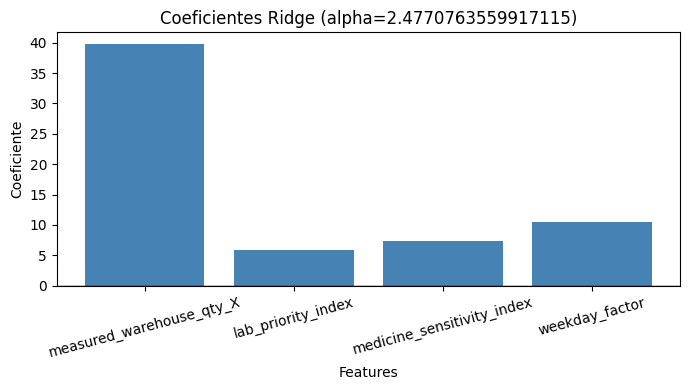

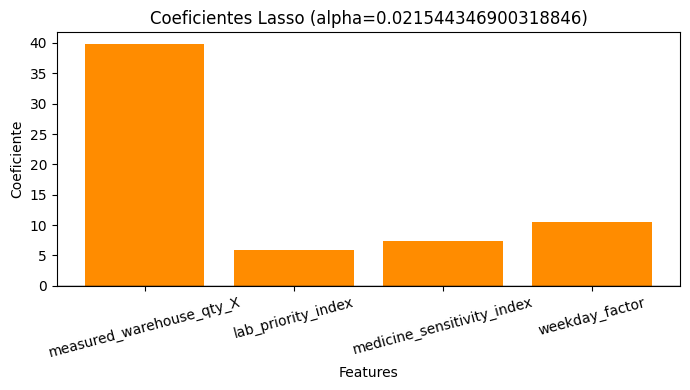

In [ ]:
# Plotagem de gráfico de coeficientes utilizando regressão Ridge
plt.figure(figsize=(7, 4))
plt.bar(features, ridge_coefs_final, color='steelblue')
plt.title(f"Coeficientes Ridge (alpha={best_alpha_ridge})")
plt.xlabel("Features")
plt.ylabel("Coeficiente")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plotagem de gráfico de coeficientes utilizando regressão Lasso
plt.figure(figsize=(7, 4))
plt.bar(features, lasso_coefs_final, color='darkorange')
plt.title(f"Coeficientes Lasso (alpha={best_alpha_lasso})")
plt.xlabel("Features")
plt.ylabel("Coeficiente")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Regularização é uma técnica usada para controlar o tamanho dos coeficientes (β) de um modelo, evitando que ele se ajuste demais aos dados de treino (overfitting). Ela adiciona uma penalização à função de custo, forçando o modelo a preferir soluções mais “simples”.

Sem regularização, o modelo ajusta os coeficientes livremente para minimizar o erro.
Com regularização:
- Coeficientes grandes (indicando alta influência de uma feature) são reduzidos.
- Em alguns casos (como no Lasso), coeficientes podem ser zerados — removendo variáveis irrelevantes.

O impacto direto é:
- Menor variância (modelo mais estável).
- Pequeno aumento no viés (modelo menos sensível a ruído).

##Ridge (L2):
Todas as linhas (coeficientes) diminuem suavemente conforme α cresce. Nenhum coeficiente zera. O modelo fica mais “equilibrado” e estável.

##Lasso (L1):
Várias linhas zeram de forma abrupta conforme α aumenta. O modelo “descarta” features irrelevantes automaticamente. Nenhum coeficiente foi excluído do modelo.

<br>

O alfa encontrado na validação é justamente o ponto que equilibra desempenho e regularização. É perceptível que a quantidade de insumos medida em cada almoxarifado é um fator decisivo para a inferência do modelo de regressão.

#**Regressão Polinomial de 2º e 3º Grau**

O objetivo de usar regressão polinomial + Ridge/Lasso é visualizar como a modelagem não-linear captura padrões complexos:

- **Regressão linear** → Linha reta → Captura apenas tendência linear
- **Polinomial de 2º grau**	→ Curvatura simples (U ou inverso de U)
- **Polinomial de 3º grau**	→ Curvatura mais complexa (S ou mudança de inclinação)
- **Regressão de Ridge** → Coeficientes suavizados → Evita overfitting
- **Regressão de Lasso** → Alguns termos polinomiais podem zerar → Curva simplificada

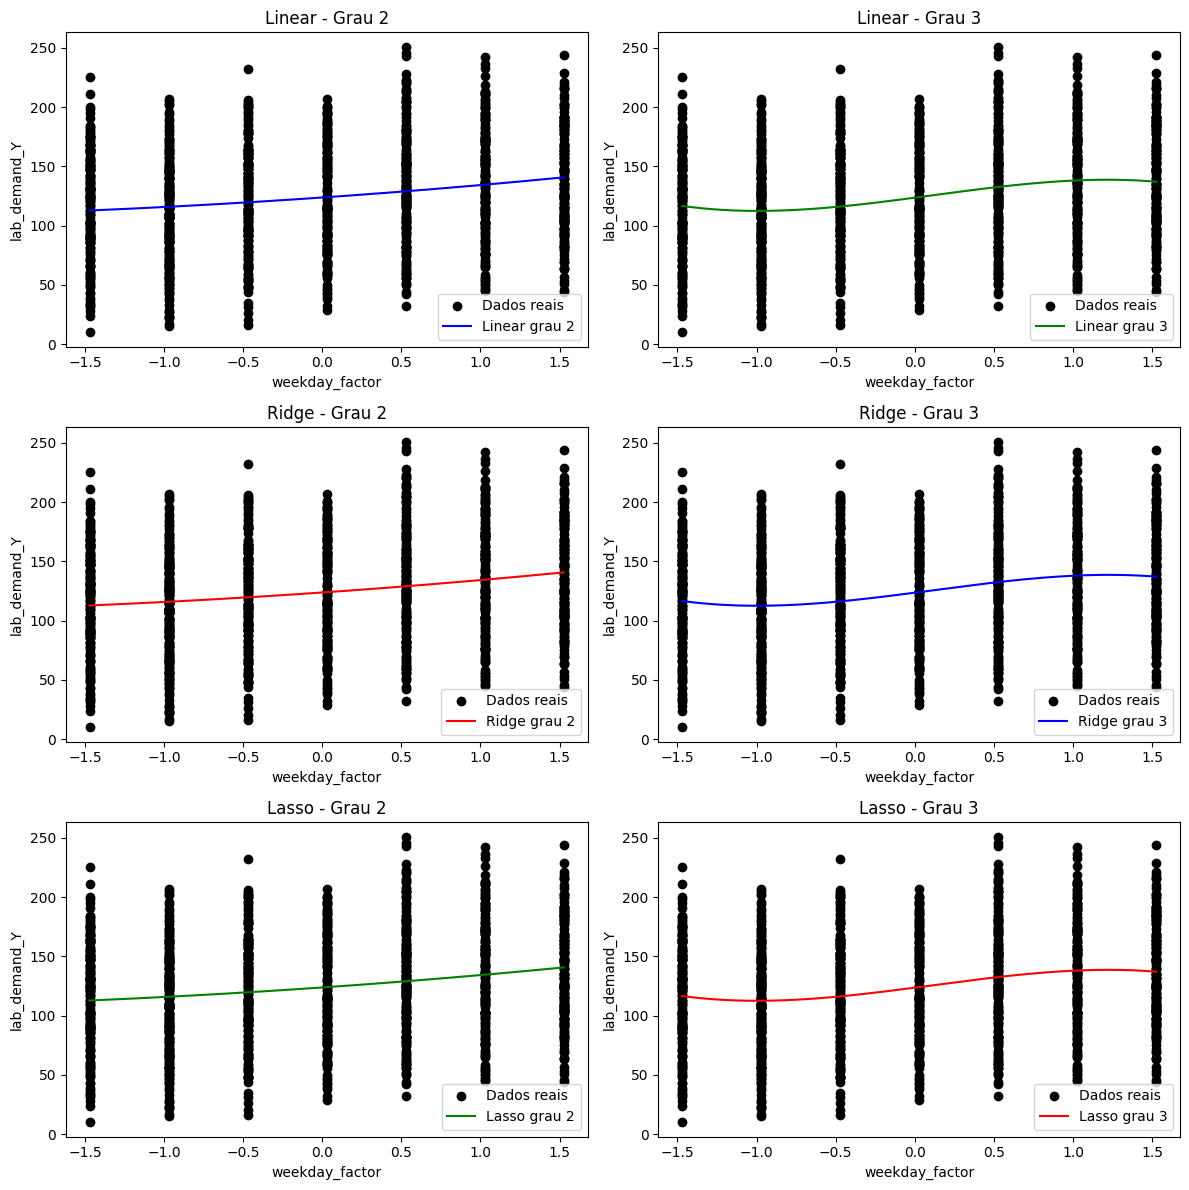

In [ ]:
x_feature = 'weekday_factor'
X_plot = X_scaled[:, X.columns.get_loc(x_feature)].reshape(-1, 1)  # coluna específica para plot

# Modelos e tipos de regressão
models = {
    'Linear': LinearRegression(),
    'Ridge': ridge_final,
    'Lasso': lasso_final
}

degrees = [2, 3]  # polinomial de grau 2 e 3
colors = ['blue', 'green', 'red']

# Configura figura 3 linhas x 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # facilita iterar

plot_idx = 0
for model_name, model in models.items():
    for deg in degrees:
        # Cria pipeline polinomial
        poly_model = Pipeline([
            ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
            ('model', model)
        ])
        poly_model.fit(X_plot, y)

        # Gera linha de previsão
        x_range = np.linspace(X_plot.min(), X_plot.max(), 200).reshape(-1, 1)
        y_pred = poly_model.predict(x_range)

        # Plot
        ax = axes[plot_idx]
        ax.scatter(X_plot, y, color='black', label='Dados reais')
        ax.plot(x_range, y_pred, color=colors[plot_idx % 3], label=f'{model_name} grau {deg}')
        ax.set_title(f'{model_name} - Grau {deg}')
        ax.set_xlabel(x_feature)
        ax.set_ylabel('lab_demand_Y')
        ax.legend()
        plot_idx += 1

plt.tight_layout()
plt.show()

Observações

Utilizando a feature de fator diário da semana, o efeito do target y (demanda do laboratório) sobre ela muda de intensidade ou sinal perceptivelmente ao utilizar regressão polinomial de 3º grau.

- **Curvatura acentuada** → feature tem efeito não-linear forte.
- **Curva achatada / quase reta** → efeito da feature é quase linear ou regularização forte está “achatando” os coeficientes.
- **Mudança de direção da curva** → ponto crítico onde a influência da feature sobre y muda.

In [ ]:
# Rechamada de modelo de regressão linear combinada com Ridge
ridge_final = Ridge(alpha=best_alpha_ridge)
ridge_final.fit(X_scaled, y)

y_pred = ridge_final.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

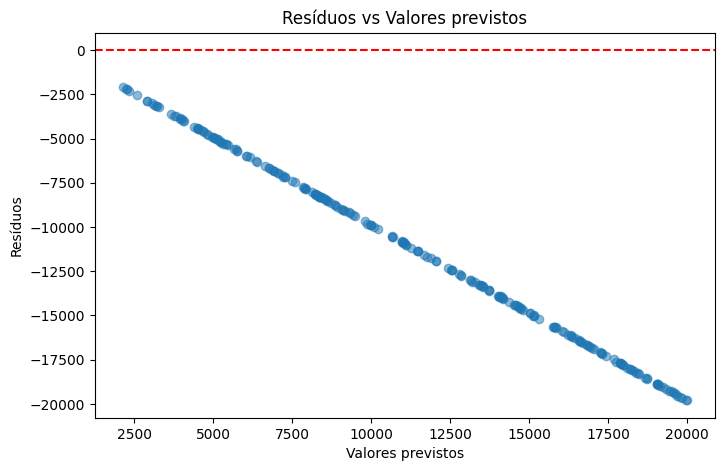

In [ ]:
# Resíduos
residuos = y_test - y_pred

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores previstos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores previstos")
plt.show()

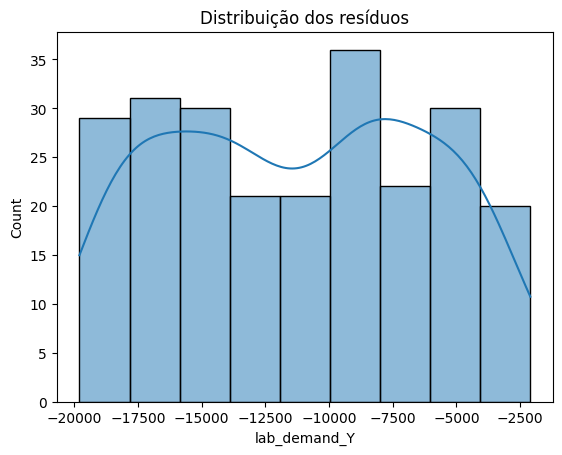

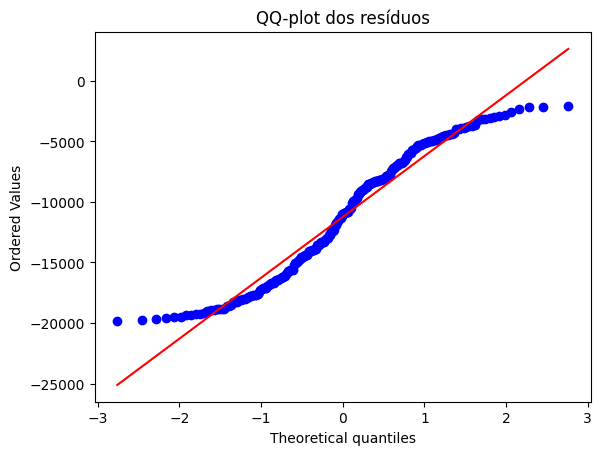

In [ ]:
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Histograma + densidade
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos resíduos")
plt.show()

# QQ-plot
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("QQ-plot dos resíduos")
plt.show()

#**Métricas**

In [ ]:
FEATURES = [
    "measured_warehouse_qty_X",
    "lab_priority_index",
    "medicine_sensitivity_index",
    "weekday_factor",
]

TARGET = "lab_demand_Y"

X = df[FEATURES].copy()
y = df[TARGET].copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = ridge_final

cv = cross_validate(
    model, X, y,
    cv=kf,
    scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
    return_train_score=True
)

resultados_folds = pd.DataFrame({
    "R2_train":        cv["train_r2"],
    "R2_val":          cv["test_r2"],
    "MAE_train":      -cv["train_neg_mean_absolute_error"],
    "MAE_val":        -cv["test_neg_mean_absolute_error"],
    "RMSE_train":     -cv["train_neg_root_mean_squared_error"],
    "RMSE_val":       -cv["test_neg_root_mean_squared_error"],
})

resumo = pd.DataFrame({
    "Métrica": ["R2", "MAE", "RMSE"],
    "Treino (média ± std)": [
        f"{resultados_folds['R2_train'].mean():.3f} ± {resultados_folds['R2_train'].std():.3f}",
        f"{resultados_folds['MAE_train'].mean():.2f} ± {resultados_folds['MAE_train'].std():.2f}",
        f"{resultados_folds['RMSE_train'].mean():.2f} ± {resultados_folds['RMSE_train'].std():.2f}",
    ],
    "Validação (média ± std)": [
        f"{resultados_folds['R2_val'].mean():.3f} ± {resultados_folds['R2_val'].std():.3f}",
        f"{resultados_folds['MAE_val'].mean():.2f} ± {resultados_folds['MAE_val'].std():.2f}",
        f"{resultados_folds['RMSE_val'].mean():.2f} ± {resultados_folds['RMSE_val'].std():.2f}",
    ],
})
print("\nResumo (média ± desvio):")
display(resumo)


Resumo (média ± desvio):


,Métrica,Treino (média ± std),Validação (média ± std)
0,R2,0.809 ± 0.006,0.803 ± 0.023
1,MAE,16.34 ± 0.19,16.46 ± 0.78
2,RMSE,20.42 ± 0.21,20.58 ± 0.85


- R² Treino: 0.809
- R² Validação: 0.799
- MAE Treino: 16.32
- MAE Validação: 16.61
- RMSE Treino: 20.40
- RMSE Validação: 20.77

<br>

Não houveram médias significativamente altas para o modelo em relação a anterior quando a regressão de Ridge foi utilizada. Possivelmente o mesmo aconteceria aplicando Lasso, ou polinômios de graus diferentes.

Estratégias como estender, reduzir ruído e adicionar mais features relevantes ao dataset (minimizando quantidade de itens no almoxarifado), além de considerar polinômios tendo padrão não-linear, podem consequentemente contribuir para o aumento das métricas e do nível de explicabilidade do modelo.

#**Árvore de Decisão e Random Forest**

=== Decision Tree ===
R² treino: 0.808, R² teste: 0.694
MAE treino: 16.71, MAE teste: 18.54
RMSE treino: 20.82, RMSE teste: 24.04


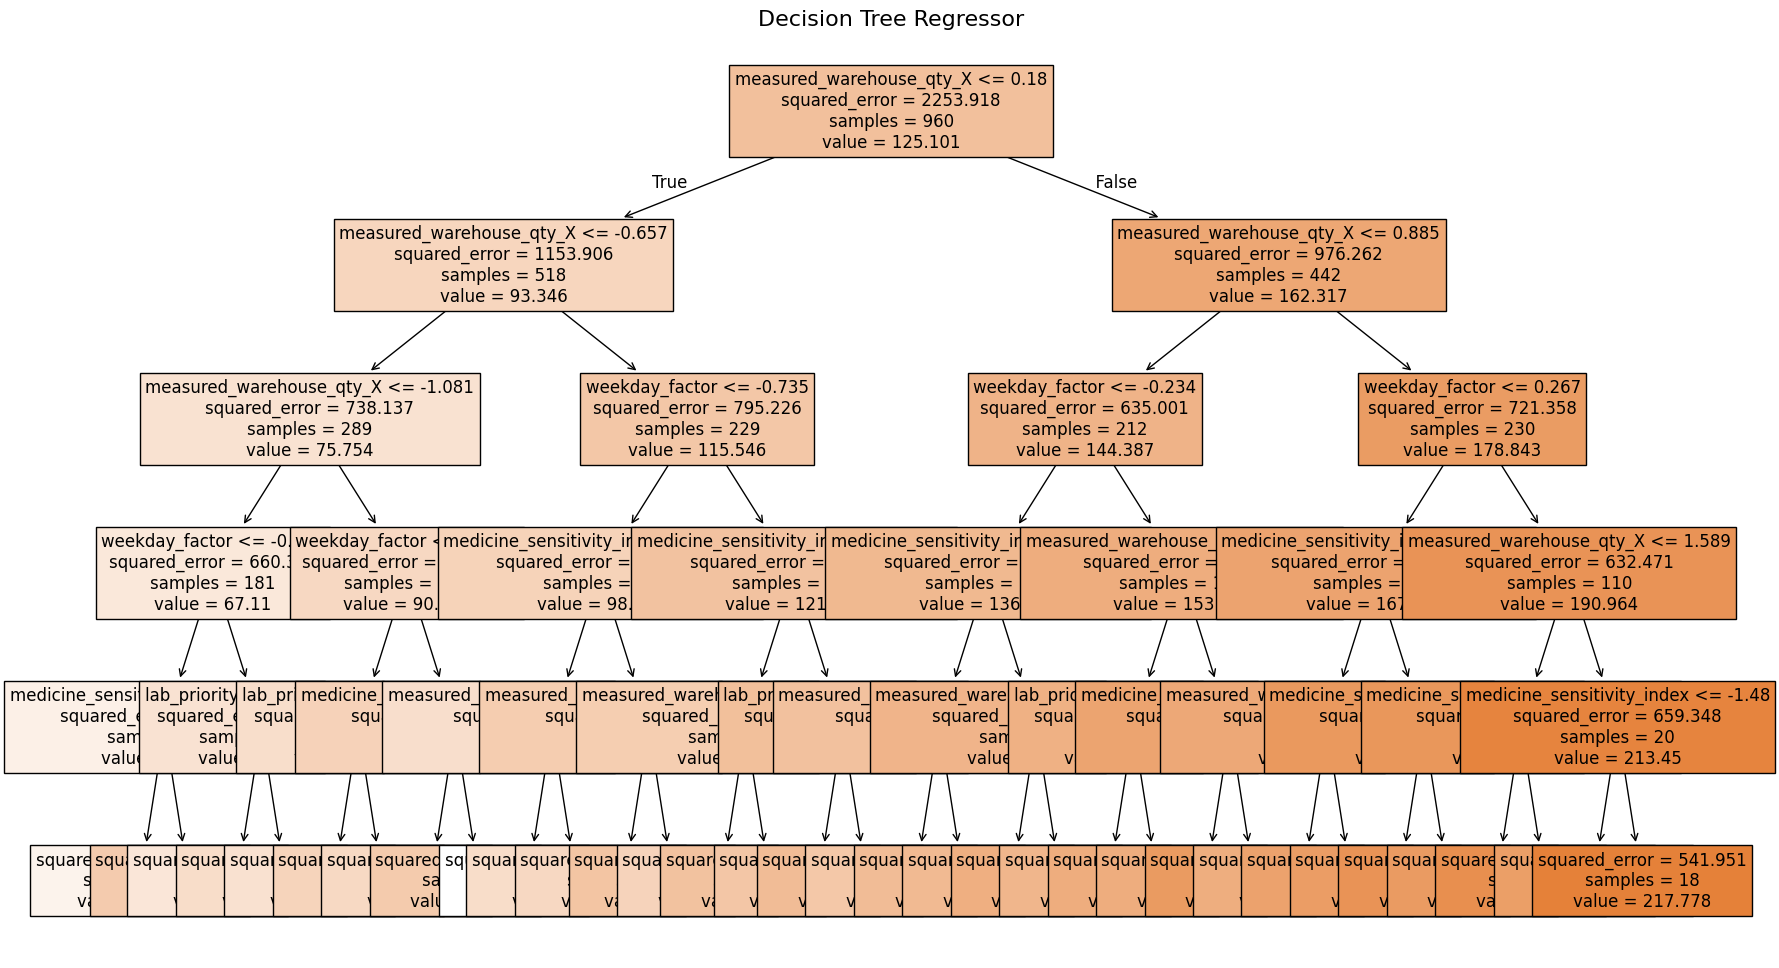


=== Random Forest ===
R² treino: 0.839, R² teste: 0.768
MAE treino: 15.48, MAE teste: 16.32
RMSE treino: 19.03, RMSE teste: 20.90


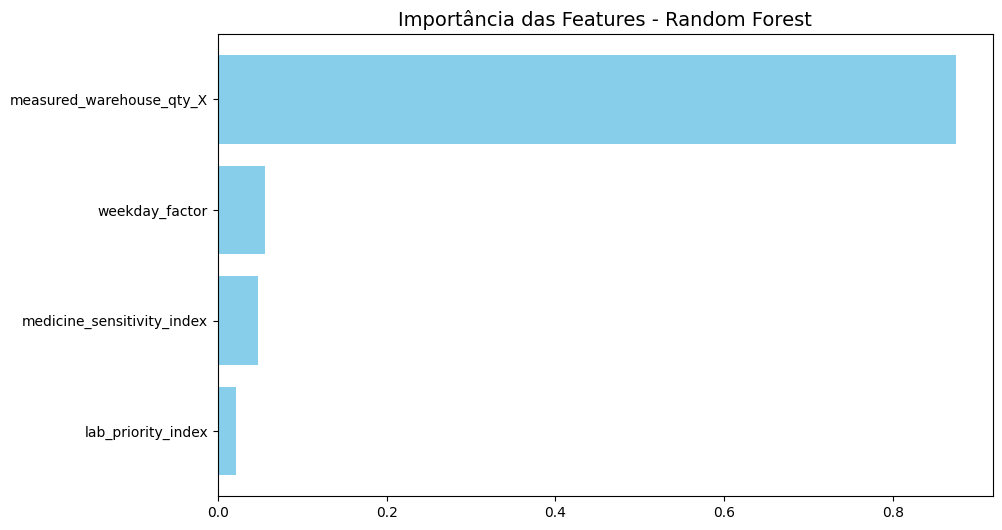

In [ ]:
# Importações
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Features e target
FEATURES = [
    "measured_warehouse_qty_X",
    "lab_priority_index",
    "medicine_sensitivity_index",
    "weekday_factor",
]
TARGET = "lab_demand_Y"

X = df[FEATURES].copy()
y = df[TARGET].copy()

# Split treino/validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronização (opcional para árvores, mas útil para comparações)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----- 1. Decision Tree -----
dt = DecisionTreeRegressor(random_state=42, max_depth=5)
dt.fit(X_train_scaled, y_train)

y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt  = dt.predict(X_test_scaled)

# Métricas DT
r2_train_dt = r2_score(y_train, y_train_pred_dt)
r2_test_dt  = r2_score(y_test, y_test_pred_dt)
mae_train_dt = mean_absolute_error(y_train, y_train_pred_dt)
mae_test_dt  = mean_absolute_error(y_test, y_test_pred_dt)
rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
rmse_test_dt  = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))

print("=== Decision Tree ===")
print(f"R² treino: {r2_train_dt:.3f}, R² teste: {r2_test_dt:.3f}")
print(f"MAE treino: {mae_train_dt:.2f}, MAE teste: {mae_test_dt:.2f}")
print(f"RMSE treino: {rmse_train_dt:.2f}, RMSE teste: {rmse_test_dt:.2f}")

# Plot árvore
plt.figure(figsize=(20,12))  # maior para ficar legível
plot_tree(dt, feature_names=FEATURES, filled=True, fontsize=12)
plt.title("Decision Tree Regressor", fontsize=16)
plt.show()

# ----- 2. Random Forest -----
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X_train_scaled, y_train)

# Previsões RF
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf  = rf.predict(X_test_scaled)

# Métricas RF
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf  = r2_score(y_test, y_test_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_rf  = mean_absolute_error(y_test, y_test_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf  = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print("\n=== Random Forest ===")
print(f"R² treino: {r2_train_rf:.3f}, R² teste: {r2_test_rf:.3f}")
print(f"MAE treino: {mae_train_rf:.2f}, MAE teste: {mae_test_rf:.2f}")
print(f"RMSE treino: {rmse_train_rf:.2f}, RMSE teste: {rmse_test_rf:.2f}")

# ----- 3. Interpretabilidade Random Forest -----
feature_importances = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))  # maior largura
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title("Importância das Features - Random Forest", fontsize=14)
plt.gca().invert_yaxis()
plt.show()